In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d nitinyadav4321/pneumonia

Dataset URL: https://www.kaggle.com/datasets/nitinyadav4321/pneumonia
License(s): apache-2.0
100% 1.14G/1.14G [00:59<00:00, 22.9MB/s]
100% 1.14G/1.14G [00:59<00:00, 20.6MB/s]


In [3]:
!unzip pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: train/NORMAL/IM-0435-0001.jpeg  
  inflating: train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: train/NORMAL/IM-0437-0001.jpeg  
  inflating: train/NORMAL/IM-0438-0001.jpeg  
  inflating: train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: train/NORMAL/IM-0439-0001.jpeg  
  inflating: train/NORMAL/IM-0440-0001.jpeg  
  inflating: train/NORMAL/IM-0441-0001.jpeg  
  inflating: train/NORMAL/IM-0442-0001.jpeg  
  inflating: train/NORMAL/IM-0444-0001.jpeg  
  inflating: train/NORMAL/IM-0445-0001.jpeg  
  inflating: train/NORMAL/IM-0446-0001.jpeg  
  inflating: train/NORMAL/IM-0447-0001.jpeg  
  inflating: train/NORMAL/IM-0448-0001.jpeg  
  inflating: train/NORMAL/IM-0449-0001.jpeg  
  inflating: train/NORMAL/IM-0450-0001.jpeg  
  inflating: train/NORMAL/IM-0451-0001.jpeg  
  in

In [4]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [5]:
train_dir = 'train/'
test_dir = 'test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

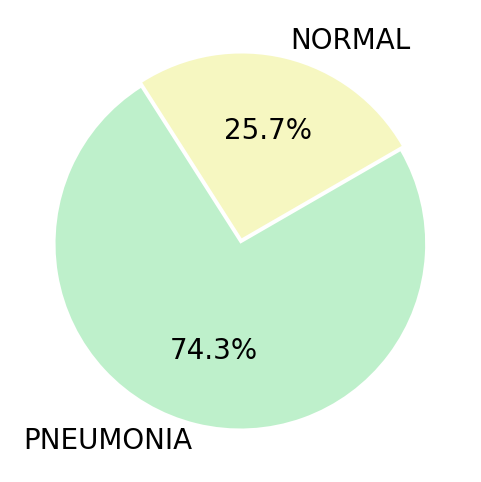

In [6]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='NORMAL']),
         len([x for x in train_labels if x=='PNEUMONIA'])],
        labels=['NORMAL','PNEUMONIA'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015),
        startangle=30);

In [7]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

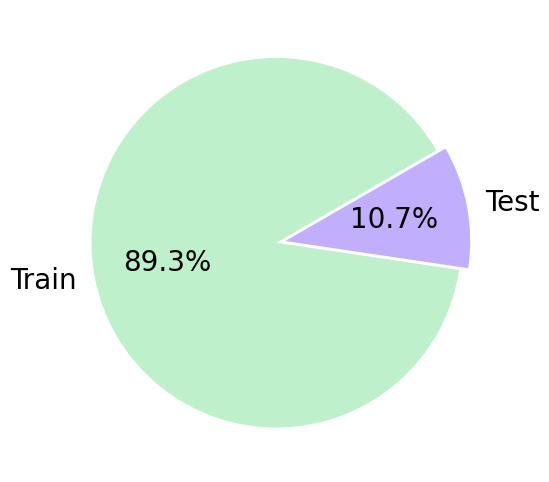

In [8]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [9]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

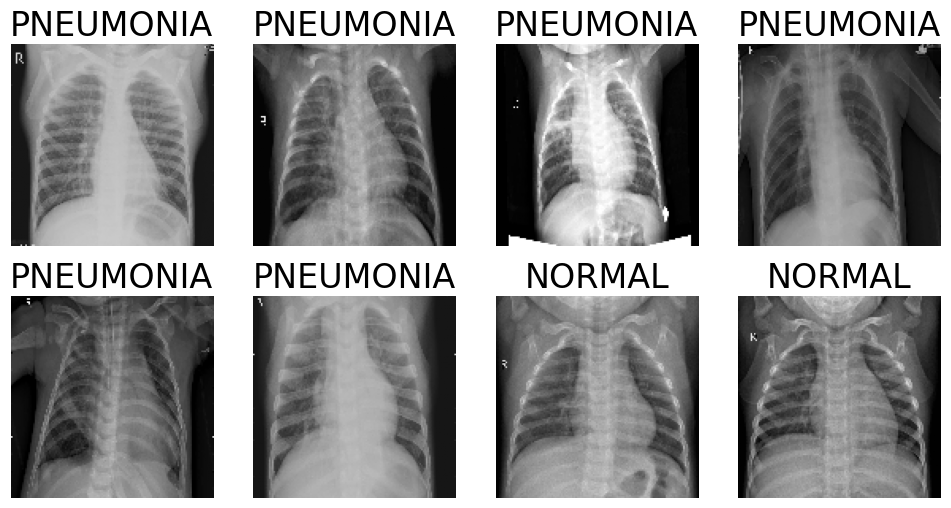

In [10]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [11]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
import numpy as np
from tqdm import tqdm
import syft as sy
import tensorflow_federated as tff

# Model parameters
IMAGE_SIZE = 224
NUM_CLASSES = 10  # Replace with your number of classes
NUM_CLIENTS = 3  # Number of federated clients
EPOCHS = 5
CLIENT_EPOCHS = 1
BATCH_SIZE = 32

# Create the model architecture
def create_model():
    base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet")

    # Freeze the layers except the last few
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(NUM_CLASSES, activation="softmax"),
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Simulated client data
def create_client_data(num_samples=500):
    x = np.random.rand(num_samples, IMAGE_SIZE, IMAGE_SIZE, 3)
    y = np.random.randint(0, NUM_CLASSES, num_samples)
    return x, y

# Federated averaging function
def federated_averaging(models):
    new_weights = [np.mean([model.get_weights()[i] for model in models], axis=0) for i in range(len(models[0].get_weights()))]
    return new_weights

# Main federated learning loop
global_model = create_model()
client_models = [create_model() for _ in range(NUM_CLIENTS)]

# Training
for epoch in tqdm(range(EPOCHS), desc="Global Training Progress", position=0):
    client_weights = []
    for client_id, client_model in enumerate(tqdm(client_models, desc=f"Epoch {epoch + 1}/{EPOCHS}: Client Training", leave=False, position=1)):
        # Simulate client data
        x_client, y_client = create_client_data()
        client_model.set_weights(global_model.get_weights())  # Initialize with global weights
        client_model.fit(x_client, y_client, epochs=CLIENT_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        client_weights.append(client_model.get_weights())

    # Aggregate updates using Federated Averaging
    averaged_weights = federated_averaging(client_models)
    global_model.set_weights(averaged_weights)

    # Evaluate global model (optional)
    x_val, y_val = create_client_data(200)
    loss, acc = global_model.evaluate(x_val, y_val, verbose=0)

# Save the final global model
global_model.save("federated_model.h5")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Global Training Progress:  20%|██        | 1/5 [01:06<04:26, 66.54s/it]

Epoch 1/5: Global Model Accuracy = 0.1200



Global Training Progress:  40%|████      | 2/5 [01:25<01:55, 38.66s/it]

Epoch 2/5: Global Model Accuracy = 0.1150



Global Training Progress:  60%|██████    | 3/5 [01:46<01:01, 30.74s/it]

Epoch 3/5: Global Model Accuracy = 0.1050



Global Training Progress:  80%|████████  | 4/5 [02:07<00:26, 26.83s/it]

Epoch 4/5: Global Model Accuracy = 0.0900



Global Training Progress: 100%|██████████| 5/5 [02:28<00:00, 29.78s/it]


Epoch 5/5: Global Model Accuracy = 0.1400


In [14]:
global_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,927,370 (68.39 MB)

 Trainable params: 10,292,106 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

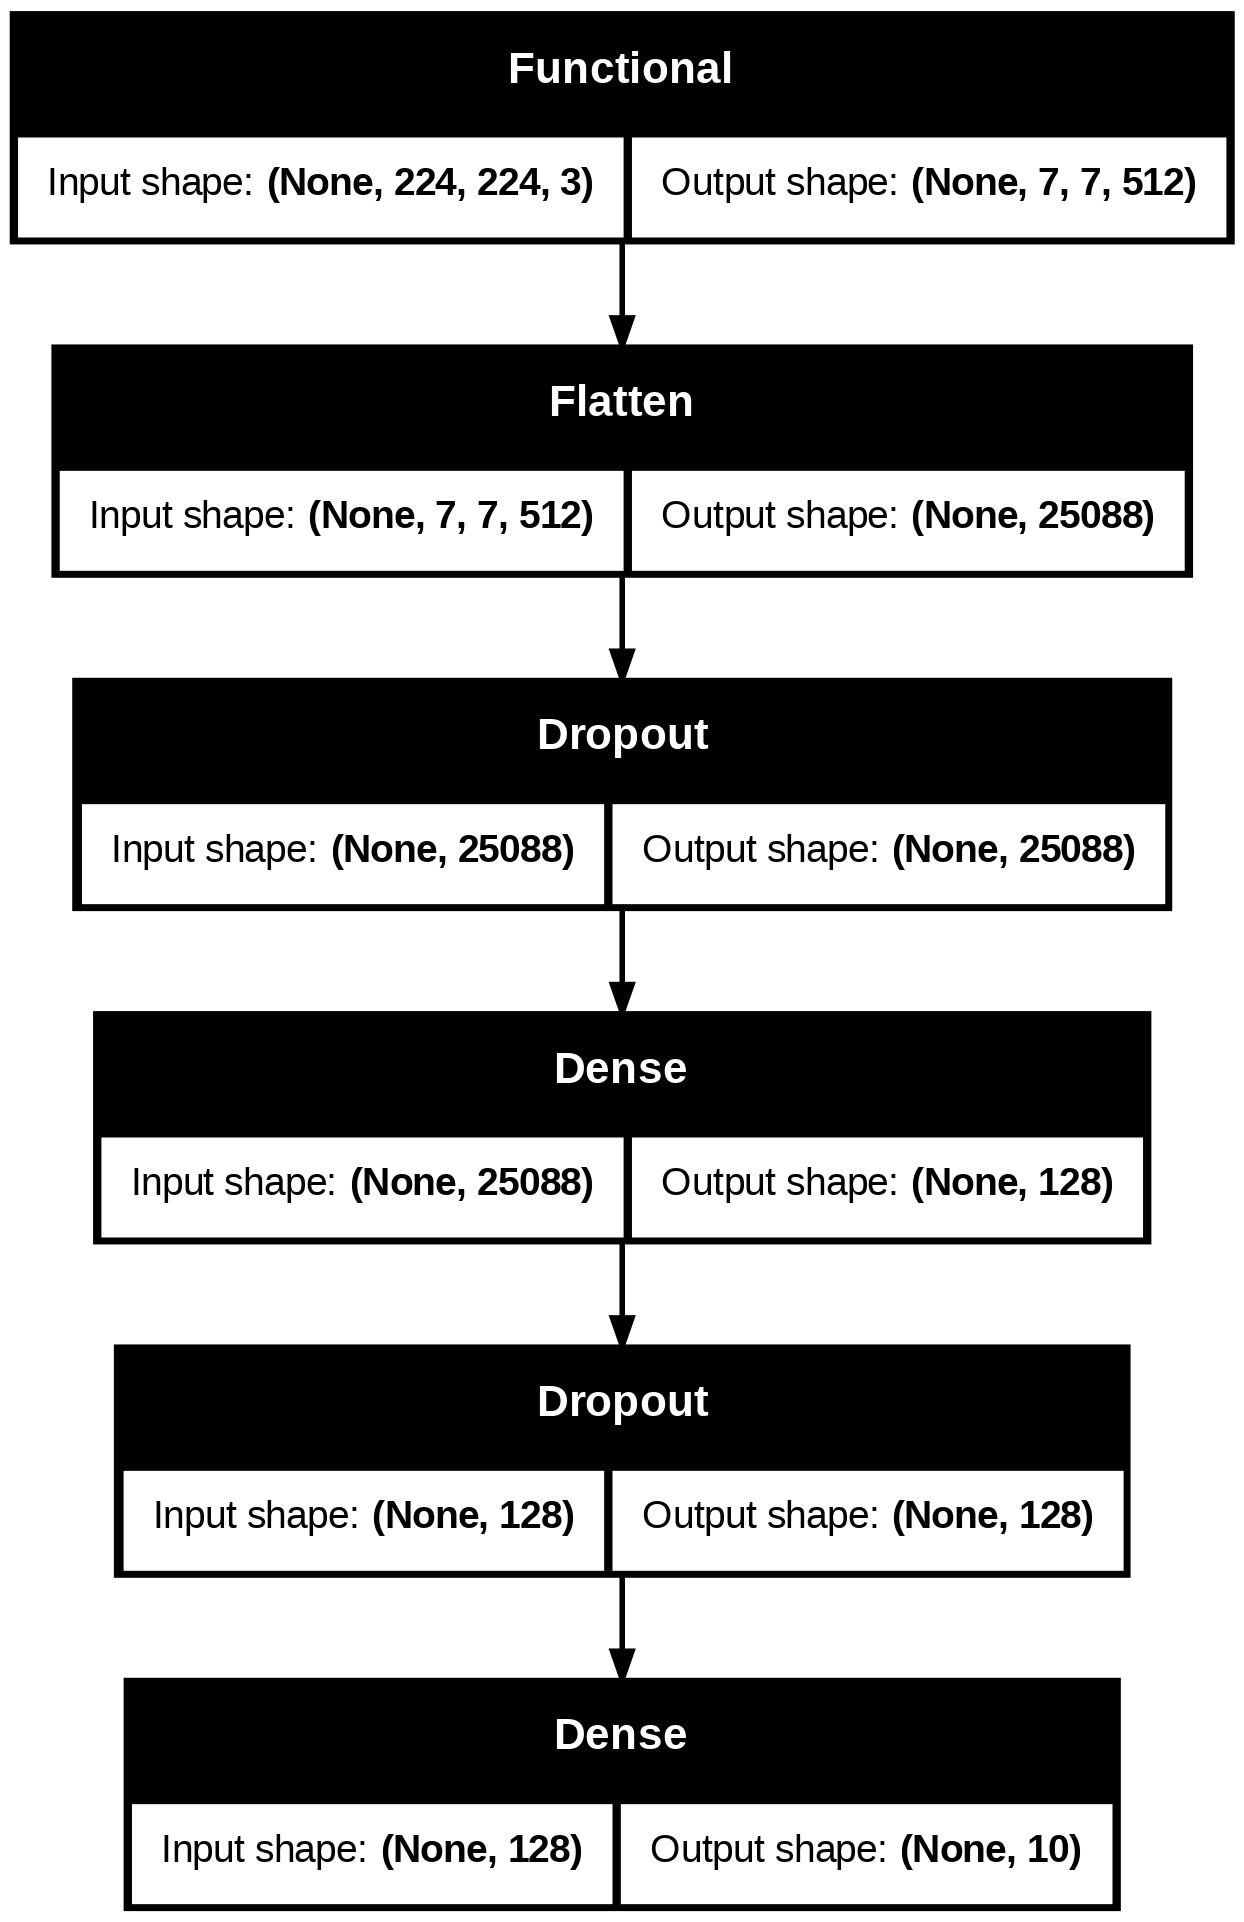

In [15]:
keras.utils.plot_model(global_model, show_shapes=True)

In [16]:
global_model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 15
history = global_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 90s 348ms/step - loss: 2.2923 - sparse_categorical_accuracy: 0.2504
Epoch 2/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 86s 360ms/step - loss: 2.2454 - sparse_categorical_accuracy: 0.2642
Epoch 3/15
 81/208 ━━━━━━━━━━━━━━━━━━━━ 39s 313ms/step - loss: 2.1981 - sparse_categorical_accuracy: 0.2718

In [ ]:
#Federated Learning Based transfer Learning enabled VGG-16 Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 10
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(global_model)
        client_model.set_weights(global_model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(global_model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], global_model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        global_model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = global_model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
global_model.save('my_model.h5')

Epoch 1/5
26/26 [==============================] - 32s 1s/step - loss: 0.0027 - sparse_categorical_accuracy: 0.9985
Epoch 2/5
26/26 [==============================] - 44s 2s/step - loss: 2.0167e-04 - sparse_categorical_accuracy: 1.0000
Epoch 3/5
26/26 [==============================] - 43s 2s/step - loss: 1.3830e-04 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
26/26 [==============================] - 42s 2s/step - loss: 1.8882e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
26/26 [==============================] - 42s 2s/step - loss: 1.2564e-04 - sparse_categorical_accuracy: 1.0000
Epoch 1/5
26/26 [==============================] - 44s 2s/step - loss: 2.3743e-04 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
26/26 [==============================] - 44s 2s/step - loss: 0.0337 - sparse_categorical_accuracy: 0.9938
Epoch 3/5
26/26 [==============================] - 42s 2s/step - loss: 2.6404e-04 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
26/26 [==============================]

  0%|          | 0/19 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 1/19 [00:02<00:52,  2.94s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 2/19 [00:05<00:48,  2.84s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 3/19 [00:08<00:44,  2.77s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 4/19 [00:11<00:41,  2.78s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 5/19 [00:13<00:38,  2.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 6/19 [00:16<00:34,  2.69s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 7/19 [00:18<00:31,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 8/19 [00:21<00:29,  2.66s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 9/19 [00:24<00:26,  2.64s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 10/19 [00:26<00:23,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 11/19 [00:29<00:21,  2.65s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 12/19 [00:32<00:18,  2.60s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 13/19 [00:34<00:15,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 14/19 [00:37<00:13,  2.61s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 15/19 [00:39<00:10,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 16/19 [00:42<00:07,  2.63s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 17/19 [00:45<00:05,  2.60s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 18/19 [00:47<00:02,  2.64s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 19/19 [00:50<00:00,  2.62s/it]

1/1 [==============================] - 1s 1s/step


20it [00:52,  2.61s/it]                        
C:\Users\shrey\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import sklearn.metrics

accuracy_score = sklearn.metrics.accuracy_score(y_true, y_pred)
accuracy_score

0.9438202247191011

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       1.00      0.79      0.89       146
   PNEUMONIA       0.93      1.00      0.96       388

    accuracy                           0.94       534
   macro avg       0.96      0.90      0.92       534
weighted avg       0.95      0.94      0.94       534



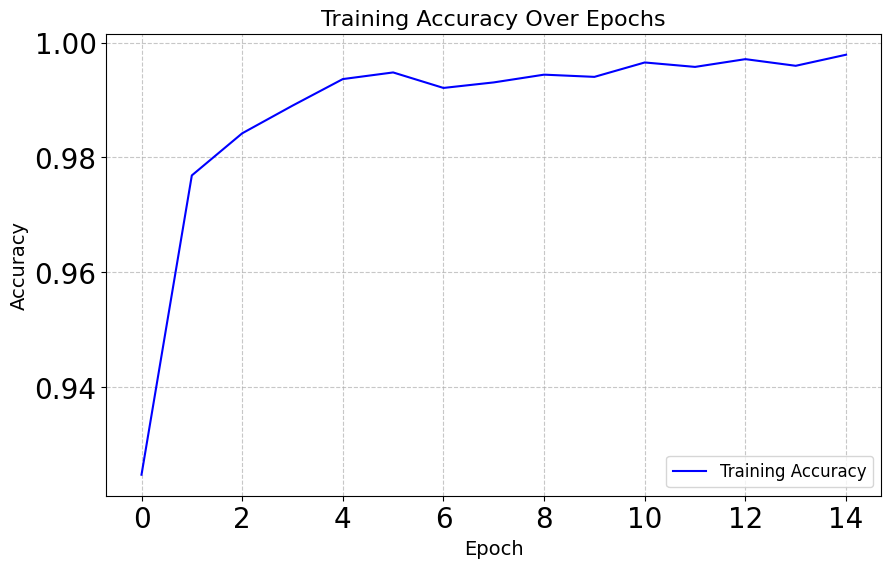

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy', color='blue', linestyle='-')

# Adding titles and labels
plt.title('Training Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(loc='lower right', fontsize=12)

# Show plot
plt.show()


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       1.00      0.79      0.89       146
   PNEUMONIA       0.93      1.00      0.96       388

    accuracy                           0.94       534
   macro avg       0.96      0.90      0.92       534
weighted avg       0.95      0.94      0.94       534



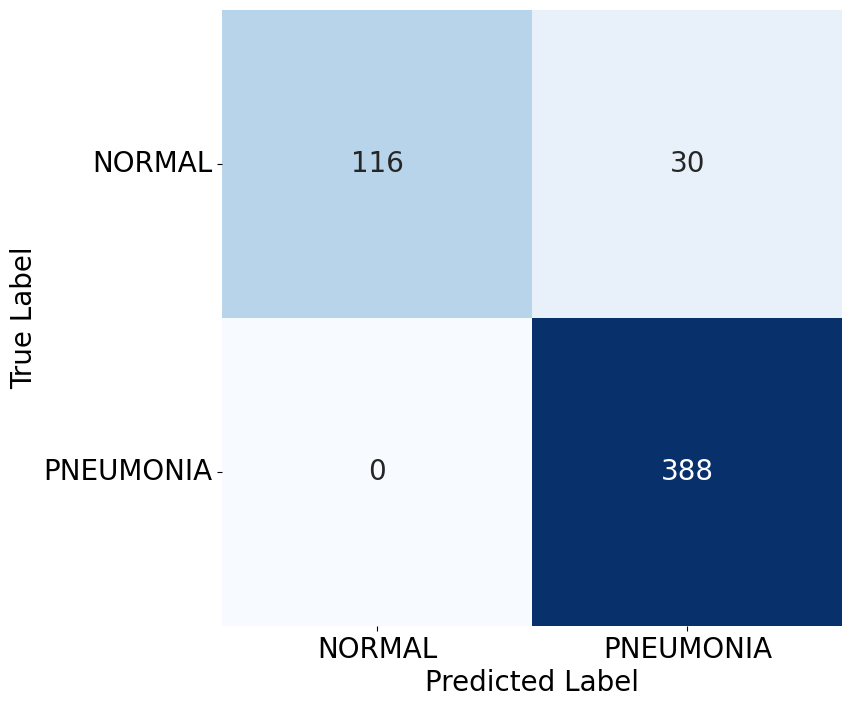

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()